# Maximisation de la fonction de vraissemblance 

In [184]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize
from datetime import datetime, timedelta
from scipy.integrate import quad
import random

## Quelques notations 

- $X \equiv$ un vecteur contenant les déterminants observables de $T_s$ et $T_d$ (genre, jour de naissance, département de naissance, etc.)

- $\tau_{birth} \equiv$ la date de naissance de l'individu

- $\tau_{contract} \equiv$ la date de la vente en viager

- $\tau_{begin} \equiv$ la date du début de la période d'observation des fichiers INSEE (1-1-1970)

- $\tau_{end} \equiv$ la date de la fin de la période d'observation des fichiers INSEE (1-6-2023)

- $V_d \equiv$ une variable captant l'effet des déterminants inobservables de $T_d$ (état de santé, richesse, niveau d'éducation)

- $V_s \equiv$ une variable captant l'effet des déterminants inobservables de $T_s$ (potentiellement les mêmes variables que celles captées par $V_d$, une variable indiquant si la personne a des enfants, une autre variable indiquant si elle a perdu son conjoint, etc.)

- $V \equiv (V_d,V_s)$

La distribution de $T_d$ conditionnellement à $T_s$, $X$ et $V$, notée $T_d|T_s,X,V$, est complètement caractérisée par le taux de hasard (comme $T_d$ représente une durée de vie il s'agit en fait d'un taux de mortalité) :
\begin{equation*}
\underset{\Delta \downarrow 0}{\text{lim}} \frac{Pr(t \leq T_d< t
+\Delta |T_d \geq t,T_s=t_s,X=x, V=v)}{\Delta} \equiv \theta_d(t|t_s,x,v).
\end{equation*}

Donc $\theta_d(t|t_s,x,v)\Delta$ s'interprète comme la probabilité qu'une personne décède durant l'interval $[t,t+{\Delta})$ sachant $T_s$, $X$ et $V$, et le fait que cette personne soit toujours vivante à l'âge $t$.

De la même manière, la distribution de $T_s$ conditionnellement à $X$ et $V$ est complètement déterminée par le taux de hasard
\begin{equation*}
\underset{\Delta \downarrow 0}{\text{lim}} \frac{Pr(t \leq T_s< t
+\Delta |T_s \geq t,X=x, V=v)}{\Delta} \equiv \theta_s(t|x,v).
\end{equation*}

Finalement, on note $F_d(t|t_s,x,v)=Pr(T_d<t|T_s=t_s,X=x, V=v)$ la fonction de répartition conditionnelle de $T_d$, et $f_d(t|t_s,x,v)=\partial F_d(t|t_s,x,v)/\partial t$ la fonction de densité associée. Ces fonctions sont liées au taux de hasard $\theta_d(t|t_s,x,v)$ de la façon suivante :
\begin{equation*}
    \theta_d(t|t_s,x,v)=\frac{f_d(t|t_s,x,v)}{1-F_d(t|t_s,x,v)}
\end{equation*}
et
\begin{equation*}
1-F_d(t|t_s,x,v)=exp\left[-\int_0 ^t \theta_d(u|t_s,x,v) du \right].
\end{equation*}

Faisons maintenant l'hypothèse que les taux de hasard s'écrivent comme :

$$ \theta_d(t|t_s,x,v)=
    \lambda_d(t) \phi_d(x) v_d \text{ si } t \le t_s \\
  \theta_d(t|t_s,x,v)=
    \lambda_d(t) \phi_d(x) \delta(t,t_s,x) v_d \text{ si } t >t_s $$

et

$$ \theta_s(t|x,v)=\lambda_s(t) \phi_s(x) v_s.$$

- Les fonctions $\lambda_d(t)$ et $\lambda_s(t)$ (parfois appelés taux de hasard de base) mesurent comment les taux de hasard dépendent respectivement de la durée $T_d$ et $T_s$. 

- Les termes $\phi_d(x)$ et $\phi_x(x)$ mesurent l'effet des variables observés sur les taux de hasard. 

- La composante cruciale dans ce modèle est $\delta(t,t_s,x)$. Cette dernière fonction capte comment le taux de mortalité change après la vente en viager. Elle mesure donc comment les supplements d'argent reçus par le vendeur affecte sa durée de vie, et cet effet peut dépendre de l'âge $t$, l'âge $t_s$ auquel l'individu a vendu son bien immobilier en viager, et les caractéristiques $x$.

### 1er cas : Modèle le plus simple 

On suppose que $var(V_d)=var(V_s)=0$ et $\delta(t,t_s,x)=\delta$.

$$
\theta_d(t|t_s,x)= 
    \lambda_d \phi_d(x) \text{ si } t \le t_s\\
\theta_d(t|t_s,x)= 
    \lambda_d \phi_d(x) \delta \text{ si } t >t_s
$$

et

$$
\theta_s(t|x)=\lambda_s \phi_s(x).
$$

On a donc fait l'hypothèse que l'hétérogénéité inobservée est absente et que les durées $T_d|T_s,X$ et $T_s|X$ suivent des lois exponentielles (les taux de hasard de base $\lambda_d(t)$ et $\lambda_s(t)$ ne dépendent pas de $t$).

$L_i^{seller} \space = \space \displaystyle \frac{f_d(t_{id}^{seller}|t_{is}^{seller},x_i)f_s(t_{is}^{seller}|x_i)}{Pr(\tau_{begin}<\tau_{i,birth}+T_{id}^{seller}<\tau_{end}|X_i=x_i)} \\$ 
<br>
<br>
$= \displaystyle \frac{f_d(t_{id}^{seller}|t_{is}^{seller},x_i)f_s(t_{is}^{seller}|x_i)}{\int \left[F_d(\tau_{end}-\tau_{i,birth}|t_s,x_i)-F_d(\tau_{begin}-\tau_{i,birth}|t_s,x_i) \right] f_s(t_s|x_i)dt_s} \\$
<br>
<br>
$= \displaystyle \frac{\lambda_d \phi_d(x_i) \delta e^{-\phi_d(x_i)I_d(t_{id}^{seller},t_{is}^{seller})} \lambda_s \phi_s(x_i) e^{-\phi_s(x_i)I_s(t_{is}^{seller})}}{\int \left[e^{-\phi_d(x_i)I_d(\tau_{begin}-\tau_{i,birth},t_s)}-e^{-\phi_d(x_i)I_d(\tau_{end}-\tau_{i,birth},t_s)}\right] \lambda_s \phi_s(x_i) e^{-\phi_s(x_i)I_s(t_s)} dt_s}$
<br>
<br>
<br>
<br>

$L_i^{clone} = \displaystyle \int_{t_{id}^{clone}} ^{\infty} \frac{f_d(t_{id}^{clone}|u,x_i)f_s(u|x_i)}{Pr(\tau_{contract}<\tau_{i,birth}+T_{id}^{seller}<\tau_{end}|X_i=x_i)}du \\$
<br>
<br>
$= \displaystyle \frac{\lambda_d \phi_d(x_i)e^{-\phi_d(x_i)I_d(t_{id}^{clone})}e^{-\phi_s(x_i)I_s(t_{id}^{clone})}}{\int \left[e^{-\phi_d(x_i)I_d(\tau_{contract}-\tau_{i,birth},t_s)}-e^{-\phi_d(x_i)I_d(\tau_{end}-\tau_{i,birth},t_s)}\right] \lambda_s \phi_s(x_i) e^{-\phi_s(x_i)I_s(t_s)} dt_s}.$ <br>
<br>
<br>
On spécifie $\phi_j(x_i)=exp(x_i'\beta_j)$, $j=d,s$, où $x_i'\beta_j=x_{i1}\beta_{j1}+x_{i2}\beta_{j2}+ ...+x_{iK}\beta_{jK}$, avec $K$ le nombre de variables explicatives.

Type of solver in scikit.spicy.minimize : [Have a look](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) <br>

- ‘Nelder-Mead’  <br>

- ‘Powell’ 

- ‘CG’ 

- ‘BFGS’ 

- ‘Newton-CG’ 

- ‘L-BFGS-B’ 

- ‘TNC’ 

- ‘COBYLA’ 

- ‘SLSQP’ 

- ‘trust-constr’

- ‘dogleg’ 

- ‘trust-ncg’ 

- ‘trust-exact’ 

- ‘trust-krylov’ 

Nos variables sont :

- $x_1 = $ type_libre 

- $x_2 = $ sexe_homme

- $x_3 = $ idf 

- $x_4 = $ étranger 

- $x_5 = $ une_tete

- $x_6 = $ dec1

- $x_7 = $ dec2

- $x_8 = $ dec3

In [5]:
seller = pd.read_csv('/Users/augustincablant/Desktop/Viagers/seller.csv')

X = ['type_libre','sexe_homme','idf','etranger','une_tete','dec1','dec2','dec3']

Nous rappelons que dans le fichier seller, datetime(1960,1,1) = 0 jours (date de départ).

$\tau_{birth} \equiv$ la date de naissance de l'individu

$\tau_{contract} \equiv$ la date de la vente en viager

$\tau_{begin} \equiv$ la date du début de la période d'observation des fichiers INSEE (1-1-1970)

$\tau_{end} \equiv$ la date de la fin de la période d'observation des fichiers INSEE (1-6-2023)

In [53]:
tau_birth = seller['b_dateN'].to_list()

tau_contract = seller['dateA'].to_list()

tau_begin = (datetime(1970, 1, 1) - datetime(1960, 1, 1)).days 

tau_end = (datetime(2023, 7, 1) - datetime(1960, 1, 1)).days

Définissons quelques fonctions : 

On commence par définir $\phi $, ainsie définie : $ \phi _j (x_i) = e^{x_i ^T \beta _j}$ avec $j \in $ {$d,s$} où $\beta _d$ est un vecteur de taille 8.

In [203]:
def phiD(beta_d): # beta_d est un vecteur de taille 8
    x_i = seller[X].values 
    phi = np.dot(x_i,beta_d)
    return phi  # retourne une liste de taille N (chaque individu) 


def phiS(beta_s): #beta_d est un vecteur de taille 8
    x_i = seller[X].values 
    phi = np.dot(x_i,beta_s)
    return phi  # retourne une liste de taille N (chaque individu) 

In [205]:
phi = phiD(np.random.random(size=8))
phi

array([2.19925195, 1.28831726, 1.78947948, 2.10000357, 1.34324904,
       1.5763736 , 0.4775338 , 1.25074174, 2.12407479, 1.31194568,
       1.48007293, 0.82723688, 1.28831726, 1.73589334, 1.9035778 ,
       2.10749353, 1.29683791, 2.12407479, 1.30432788, 1.35086684,
       1.34324904, 1.76812928, 1.30477067, 1.31194568, 1.29683791,
       0.4851516 , 1.71410035, 1.71410035, 0.4851516 , 0.05402893,
       2.13918255, 1.36597461, 0.53918053, 1.48007293, 2.11511133,
       2.11511133, 2.19163414, 1.82840064, 1.48007293, 1.30477067,
       0.53918053, 0.99492133, 1.426044  , 1.31194568, 0.        ,
       2.54757966, 1.36597461, 1.31194568, 1.31194568, 2.13156475,
       1.77437171, 1.73589334, 0.81168631, 3.4799514 , 0.4851516 ,
       2.09238577, 1.36597461, 1.4184262 , 2.25328088, 2.61671635,
       0.53918053, 2.57753737, 1.30432788, 0.4851516 , 1.36597461,
       0.77320795, 1.30432788, 0.86571525, 2.22920966, 1.60000202,
       0.82679408, 2.60160859, 2.19925195, 1.29683791, 2.10749

Nous introduisons ensuite $\theta _d $, ainsi définie : $\theta _d (t|t_s,x) = \lambda _d \phi_d(x) \space $ si $ \space t \le t_s$ et $ \space \theta _d (t|t_s,x) = \lambda _d \phi_d(x) \delta \space $ si $\space t > t_s$.

In [11]:
def thetaD(lambda_d,phi_d,t,t_s, delta):
    if t <= t_s:
        theta = lambda_d * phi_d
    else: 
        theta = lambda_d * phi_d * delta
    return theta

Puis $ \theta _s(t|x) = \lambda _s \phi_s (x) $ : 

In [12]:
def thetaS(lambda_s,phi_s):
    theta = lambda_s * phi_s 
    return theta

$ I_d(t_1,t_2) = \lambda_d (t_2 + \delta (t_1 - t_2))  $ si $t_1 > t_2$ et $ I_d(t_1,t_2) = \lambda _d t_1 $ si $t_1 \le t_2$

$ I_d(t) = \lambda_d t $

$ I_s(t) = \lambda _s t $ 

In [138]:
def IDD(delta,lambda_d,t_1,t_2): 
    if t_1 <= t_2:
        I = lambda_d * t_1
    else: 
        I = lambda_d * (t_2 + delta * (t_1 - t_2))
    return I 


def ID(lambda_d,t):
    I = lambda_d * t
    return I 

def IS(lambda_s,t):
    I = lambda_s * t
    return I 

Définir $L_i ^{seller}$ et $L_i ^{clone}$ : 

- $L_i ^{seller} = \displaystyle \frac{\lambda_d \phi_d(x_i) \delta e^{-\phi_d(x_i)I_d(t_{id}^{seller},t_{is}^{seller})} \lambda_s \phi_s(x_i) e^{-\phi_s(x_i)I_s(t_{is}^{seller})}}{\int \left[e^{-\phi_d(x_i)I_d(\tau_{begin}-\tau_{i,birth},t_s)}-e^{-\phi_d(x_i)I_d(\tau_{end}-\tau_{i,birth},t_s)}\right] \lambda_s \phi_s(x_i) e^{-\phi_s(x_i)I_s(t_s)} dt_s} $
<br>
<br>

- $L_i^{clone} = \displaystyle \frac{\lambda_d \phi_d(x_i)e^{-\phi_d(x_i)I_d(t_{id}^{clone})}e^{-\phi_s(x_i)I_s(t_{id}^{clone})}}{\int \left[e^{-\phi_d(x_i)I_d(\tau_{contract}-\tau_{i,birth},t_s)}-e^{-\phi_d(x_i)I_d(\tau_{end}-\tau_{i,birth},t_s)}\right] \lambda_s \phi_s(x_i) e^{-\phi_s(x_i)I_s(t_s)} dt_s}.$ 


Le dénominateur peut se réécrire : 

$ \int \left[e^{-\phi_d(x_i)I_d(\tau_{begin}-\tau_{i,birth},t_s)}-e^{-\phi_d(x_i)I_d(\tau_{end}-\tau_{i,birth},t_s)}\right] \lambda_s \phi_s(x_i) e^{-\phi_s(x_i)I_s(t_s)} dt_s = $ 

In [139]:
T_d_seller = seller['Td'].to_list()
T_s_seller = seller['Ts'].to_list()

T_d_clone = seller['Td_clone'].to_list()
T_s_clone = seller['Ts_clone'].to_list()

In [211]:
def LSeller_i(lambda_d, lambda_s, phi_d, phi_s,delta, T_d_seller, T_d_clone, T_s_seller, T_s_clone,i):

    # numérateur
    numerateur_d_exp =  np.exp(-(phi_d[i] * IDD(delta,lambda_d,T_d_seller[i],T_s_seller[i])))
    numerateur_d = lambda_d * phi_d[i] * delta * numerateur_d_exp

    numerateur_s_exp = np.exp(-(phi_s[i] * IS(lambda_s,T_s_seller[i])))
    numerateur_s = lambda_s * phi_s[i] * numerateur_s_exp

    numerateur = numerateur_d * numerateur_s

    # dénominateur 
    def f(t_s):
        exp_1 = np.exp(- phi_d[i] * IDD(delta,lambda_d,tau_contract[i] - tau_birth[i], t_s))
        exp_2 = np.exp(- phi_d[i] * IDD(delta,lambda_d,tau_end - tau_birth[i],t_s))
        left = exp_1 - exp_2
        exp_right = np.exp(- phi_s[i] * IS(lambda_s,t_s))
        right = lambda_s * phi_s[i] * exp_right
        integrande = left * right 
        return integrande

    denominateur = quad(f, 0, 10000,epsabs=1e-2)[0]
    print(denominateur)
    resultat = numerateur / denominateur
    return resultat


def LClone_i(lambda_d, lambda_s, phi_d, phi_s,delta, T_d_seller, T_d_clone, T_s_seller, T_s_clone,i):
    # numérateur
    numerateur_d_exp =  np.exp(-(phi_d[i] * ID(lambda_d,T_d_clone[i])))
    numerateur_d = lambda_d * phi_d[i] * numerateur_d_exp

    numerateur_s_exp = np.exp(-(phi_s[i] * IS(lambda_s,T_s_clone[i])))
    numerateur_s = numerateur_s_exp

    numerateur = numerateur_d * numerateur_s

    # dénominateur 
    def f(t_s):
        exp_1 = np.exp(- phi_d[i] * IDD(delta,lambda_d,tau_contract[i] - tau_birth[i], t_s))
        exp_2 = np.exp(- phi_d[i] * IDD(delta,lambda_d,tau_end - tau_birth[i],t_s))
        left = exp_1 - exp_2
        exp_right = np.exp(- phi_s[i] * IS(lambda_s,t_s))
        right = lambda_s * phi_s[i] * exp_right
        integrande = left * right 
        return integrande

    denominateur = quad(f, 0, 10000,epsabs=1e-2)[0]
    print(denominateur)
    resultat = numerateur / denominateur
    return resultat

Passons au calcul de la fonction de vraisemblance : 

$$ L = \displaystyle \prod _{i=1} ^N L_i = \displaystyle \prod _{i=1} ^N L_i ^{seller} . \space L_i ^{clone}$$

In [212]:
# Définir la fonction de vraisemblance (à maximiser) 
def likelihood(parameters):

    # Paramètres à trouver
    # lambda_d, lambda_s et delta des réels 
    # beta_d et beta_s des vecteurs de taille N
    parameters = list(parameters)
    lambda_d = parameters[0]
    lambda_s = parameters[1]
    beta_d = list(parameters[2:10])
    beta_s = list(parameters[10:18])
    delta = parameters[-1]

    # Utiliser nos fonctions 
    phi_d = phiD(beta_d)
    phi_d[phi_d == np.float(0)] = 0.1
    phi_s = phiS(beta_s)
    phi_s[phi_s == np.float(0)] = 0.1

    L_seller_vector = []
    L_clone_vector = []

    for i in seller.index.to_list(): 
        L_seller_vector.append(LSeller_i(lambda_d, lambda_s, phi_d, phi_s,delta, T_d_seller, T_d_clone, T_s_seller, T_s_clone,i))
        L_clone_vector.append(LClone_i(lambda_d, lambda_s, phi_d, phi_s,delta, T_d_seller, T_d_clone, T_s_seller, T_s_clone,i))

    L_seller_vector = np.array(L_seller_vector)
    L_clone_vector = np.array(L_clone_vector)
    L_vector = L_seller_vector * L_clone_vector
    Likelihood = np.prod(L_vector)
    
    return -Likelihood # Retourner le négatif de la vraisemblance car minimize va minimiser la fonction

Minimiser l'opposé de la fonction de vraisemblance :

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_d[phi_d == np.float(0)] = 0.1
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_2549/170306267.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phi_s[phi_s == np.float(0)] = 0.1
/var/folders/bt/r1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


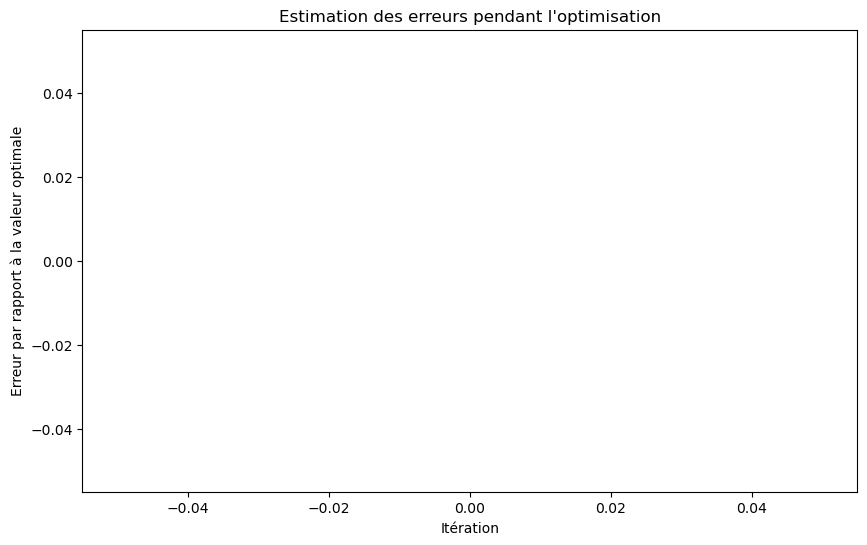

In [213]:
# Initialisation des paramètres
l_d = random.uniform(1,5)
l_s = random.uniform(1,5)

beta_D_1 = random.uniform(1,5)
beta_D_2 = random.uniform(1,5)
beta_D_3 = random.uniform(1,5)
beta_D_4 = random.uniform(1,5)
beta_D_5 = random.uniform(1,5)
beta_D_6 = random.uniform(1,5)
beta_D_7 = random.uniform(1,5)
beta_D_8 = random.uniform(1,5)

beta_S_1 = random.uniform(1,5)
beta_S_2 = random.uniform(1,5)
beta_S_3 = random.uniform(1,5)
beta_S_4 = random.uniform(1,5)
beta_S_5 = random.uniform(1,5)
beta_S_6 = random.uniform(1,5)
beta_S_7 = random.uniform(1,5)
beta_S_8 = random.uniform(1,5)

thet = random.uniform(1,5)

initial_params = (l_d, l_s, beta_D_1, beta_D_2, beta_D_3, beta_D_4, beta_D_5, beta_D_6, beta_D_7, beta_D_8,
                  beta_S_1, beta_S_2, beta_S_3, beta_S_4, beta_S_5, beta_S_6, beta_S_7, beta_S_8, thet)



likelihood_values = []
errors = []

def callback_function(params):
    # Calculez la valeur de la fonction de vraisemblance à chaque itération
    likelihood_value = -likelihood(params)
    likelihood_values.append(likelihood_value)
    
    # Calculez l'erreur en comparant la valeur actuelle avec la valeur optimale
    error = likelihood_value - result.fun
    errors.append(error)

result = minimize(
    fun=likelihood,
    x0=initial_params,
    method='BFGS', 
    options={'maxiter': 100000, 'disp': True},  # 'disp': True pour afficher les détails de chaque itération
    callback=callback_function
)

# Les paramètres optimisés se trouvent dans result.x
optimized_params = result.x
print(optimized_params)

# Tracer l'estimation des erreurs
plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.xlabel("Itération")
plt.ylabel("Erreur par rapport à la valeur optimale")
plt.title("Estimation des erreurs pendant l'optimisation")
plt.show()

In [168]:
def h(x):
    return np.exp(-x)

quad(h, 0, np.inf)[0]

1.0000000000000002

In [195]:
numerateur

NameError: name 'numerateur' is not defined